## Assignment: Predicting House Prices

In this module, use a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)


In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

### Load the dataset from the Thinkful PostgreSQL database.

In [6]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# Use the connection to extract SQL data
house_price = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

#Close the connection after query is complete
engine.dispose()

### Investigate the data

In [7]:
#Column headers
house_price.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

In [8]:
#Datatypes for each variable
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [23]:
house_price.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [21]:
#Descriptive stats:
house_price.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Do any necessary data cleaning.

In [28]:
#Check if any values are NaN and need to be fixed or dropped
print((house_price.isnull().sum()/house_price.isnull().count()).sort_values(ascending=False).head(20))

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagecond      0.055479
garagetype      0.055479
garageyrblt     0.055479
garagefinish    0.055479
garagequal      0.055479
bsmtexposure    0.026027
bsmtfintype2    0.026027
bsmtfintype1    0.025342
bsmtcond        0.025342
bsmtqual        0.025342
masvnrarea      0.005479
masvnrtype      0.005479
electrical      0.000685
utilities       0.000000
dtype: float64


In creating a model for 'saleprice', we aren't going to need all 81 features provided in the dataset. The ones shown above, which contain some portion of NaNs, don't seem like they would be the most useful features in predicting saleprice, so, because there's only 19 of them, and we'll have plenty of features left, I feel comfortable dropping these features from the dataset entirely. Additionally, because each row has a unique 'id' value, we should remove that feature as well, since it won't affect our regression either way.

In [47]:
#Drop features
drop_list = list((house_price.isnull().sum()/house_price.isnull().count()).sort_values(ascending=False).head(19).index)
drop_list.append('id')

house_price = house_price.drop(drop_list, axis=1)

In [48]:
#Check if it was successful
house_price.columns

Index(['mssubclass', 'mszoning', 'lotarea', 'street', 'lotshape',
       'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'condition2', 'bldgtype', 'housestyle', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl',
       'exterior1st', 'exterior2nd', 'exterqual', 'extercond', 'foundation',
       'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd',
       'functional', 'fireplaces', 'garagecars', 'garagearea', 'paveddrive',
       'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch',
       'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saletype',
       'salecondition', 'saleprice'],
      dtype='object')

Now that NaNs have been dealt with, we can visualize the dataset for some basic investigation into how the features affect each other (and especially how they affect saleprice). One thing to notice: some variables are numerical and continuous (i.e. saleprice, lotarea, lotfrontage, etc) while others appear to be numerical but actually represent categories of a catgegorical variable with finite values (yearbuilt, fullbath, yrsold, etc), and the final group is that of features that appear categorical (i.e. string objects: street, mssubclass, etc). Let's get all of those variables into a format that a regression can use.

In [99]:
uniques = pd.DataFrame()
uni_col = []
num_uni = []
avgdiff_uni = []

for col in list(house_price.columns):
    uni_col.append(list(np.unique(house_price[col])))
    num_uni.append(len(np.unique(house_price[col])))
    try:
        avgdiff_uni.append(np.mean(np.diff(np.unique(house_price[col]))))
    except: 
        avgdiff_uni.append('N/A')
    
uniques['Category'] = list(house_price.columns)
uniques['Unique Values'] = uni_col
uniques['Num Uniques'] = num_uni
uniques['Avg Diff Among Uniques'] = avgdiff_uni

uniques

,Category,Unique Values,Num Uniques,Avg Diff Among Uniques
0,mssubclass,"[20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 1...",15,12.1429
1,mszoning,"[C (all), FV, RH, RL, RM]",5,N/A
2,lotarea,"[1300, 1477, 1491, 1526, 1533, 1596, 1680, 186...",1073,199.576
3,street,"[Grvl, Pave]",2,N/A
4,lotshape,"[IR1, IR2, IR3, Reg]",4,N/A
5,landcontour,"[Bnk, HLS, Low, Lvl]",4,N/A
6,utilities,"[AllPub, NoSeWa]",2,N/A
7,lotconfig,"[Corner, CulDSac, FR2, FR3, Inside]",5,N/A
8,landslope,"[Gtl, Mod, Sev]",3,N/A
9,neighborhood,"[Blmngtn, Blueste, BrDale, BrkSide, ClearCr, C...",25,N/A


In [100]:
#List of features that are string categoricals
str_cat_cols = list(house_price.describe(include=['O']).columns)

#List of features that are numerical categoricals
    #If a numerical variable is categorical, its unique values will tend to be close to each other and there shouldn't
    #be too many unique values 
num_cat_cols = []
for col in list(house_price.columns):
    if col not in str_cat_cols:   
        if ((list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 2) or ((list(uniques[uniques['Category']==col]['Num Uniques'])[0] < 20) and (list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 20))):
            num_cat_cols.append(col)
            
#List of features that are numerical continuous
cont_cols = []
for col in list(house_price.columns):
    if ((col not in str_cat_cols) and (col not in num_cat_cols)):
        cont_cols.append(col)

In [113]:
cont_cols

['lotarea',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 'firstflrsf',
 'secondflrsf',
 'lowqualfinsf',
 'grlivarea',
 'garagearea',
 'wooddecksf',
 'openporchsf',
 'enclosedporch',
 'threessnporch',
 'screenporch',
 'poolarea',
 'miscval',
 'saleprice']

### Explore the data and find some variables that you think would be useful in predicting house prices.

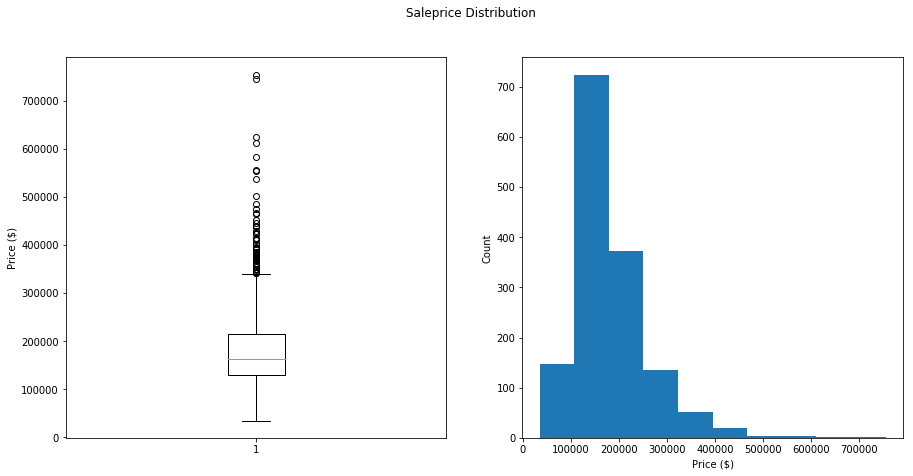

In [106]:
#Visualize data spread of our target variable, saleprice
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
box = plt.boxplot(house_price['saleprice'])
plt.ylabel('Price ($)')
  
plt.subplot(1,2,2)    
plt.hist(house_price['saleprice'])
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.suptitle('Saleprice Distribution')
plt.show()

We can see in this visualization that the saleprice data is not normally distributed. Its mean falls to the closer to the lower prices, and it stretches for a while toward the higher prices, meaning there are a lot of high outliers that could be skewing the distribution.

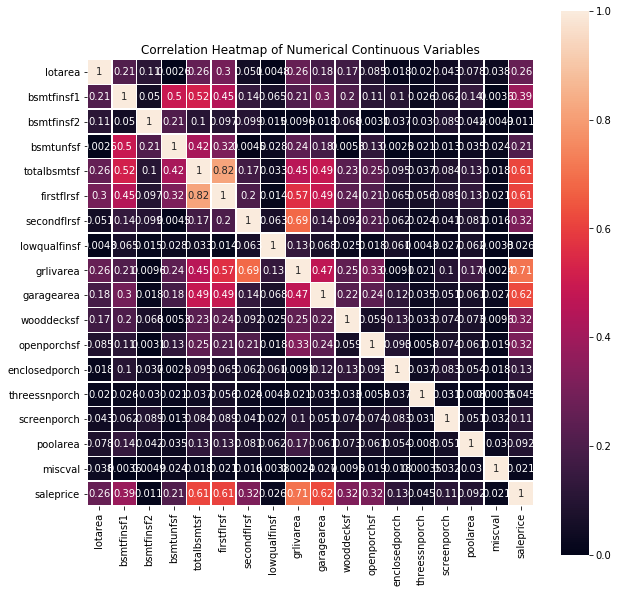

saleprice        1.000000
grlivarea        0.708624
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
lotarea          0.263843
bsmtunfsf        0.214479
screenporch      0.111447
poolarea         0.092404
threessnporch    0.044584
bsmtfinsf2      -0.011378
miscval         -0.021190
lowqualfinsf    -0.025606
enclosedporch   -0.128578
Name: saleprice, dtype: float64

In [114]:
#Compare the continuous variables and their correlations via a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(abs(house_price[cont_cols].corr()), square=True, linewidths=.5, annot=True)
plt.title('Correlation Heatmap of Numerical Continuous Variables')
plt.show()

house_price[cont_cols].corr()['saleprice'].sort_values(ascending=False)

From the correlation analysis, we can see that 'totalbsmtsf' and 'firstflrsf', 'firstflrsf' and 'grlivarea', and 'secondflrsf' and 'grlivarea' are correlated to each other, and 'grlivarea', 'garagearea', 'totalbsmtsf', and 'firstflrsf' are all highly correlated with 'saleprice'. Because of the correlations between 'firstflrsf' and both 'totalbsmtsf' and 'grlivarea', we should drop 'firstflrsf', as it would provide extraneous information and unnecessarily complicate our model.

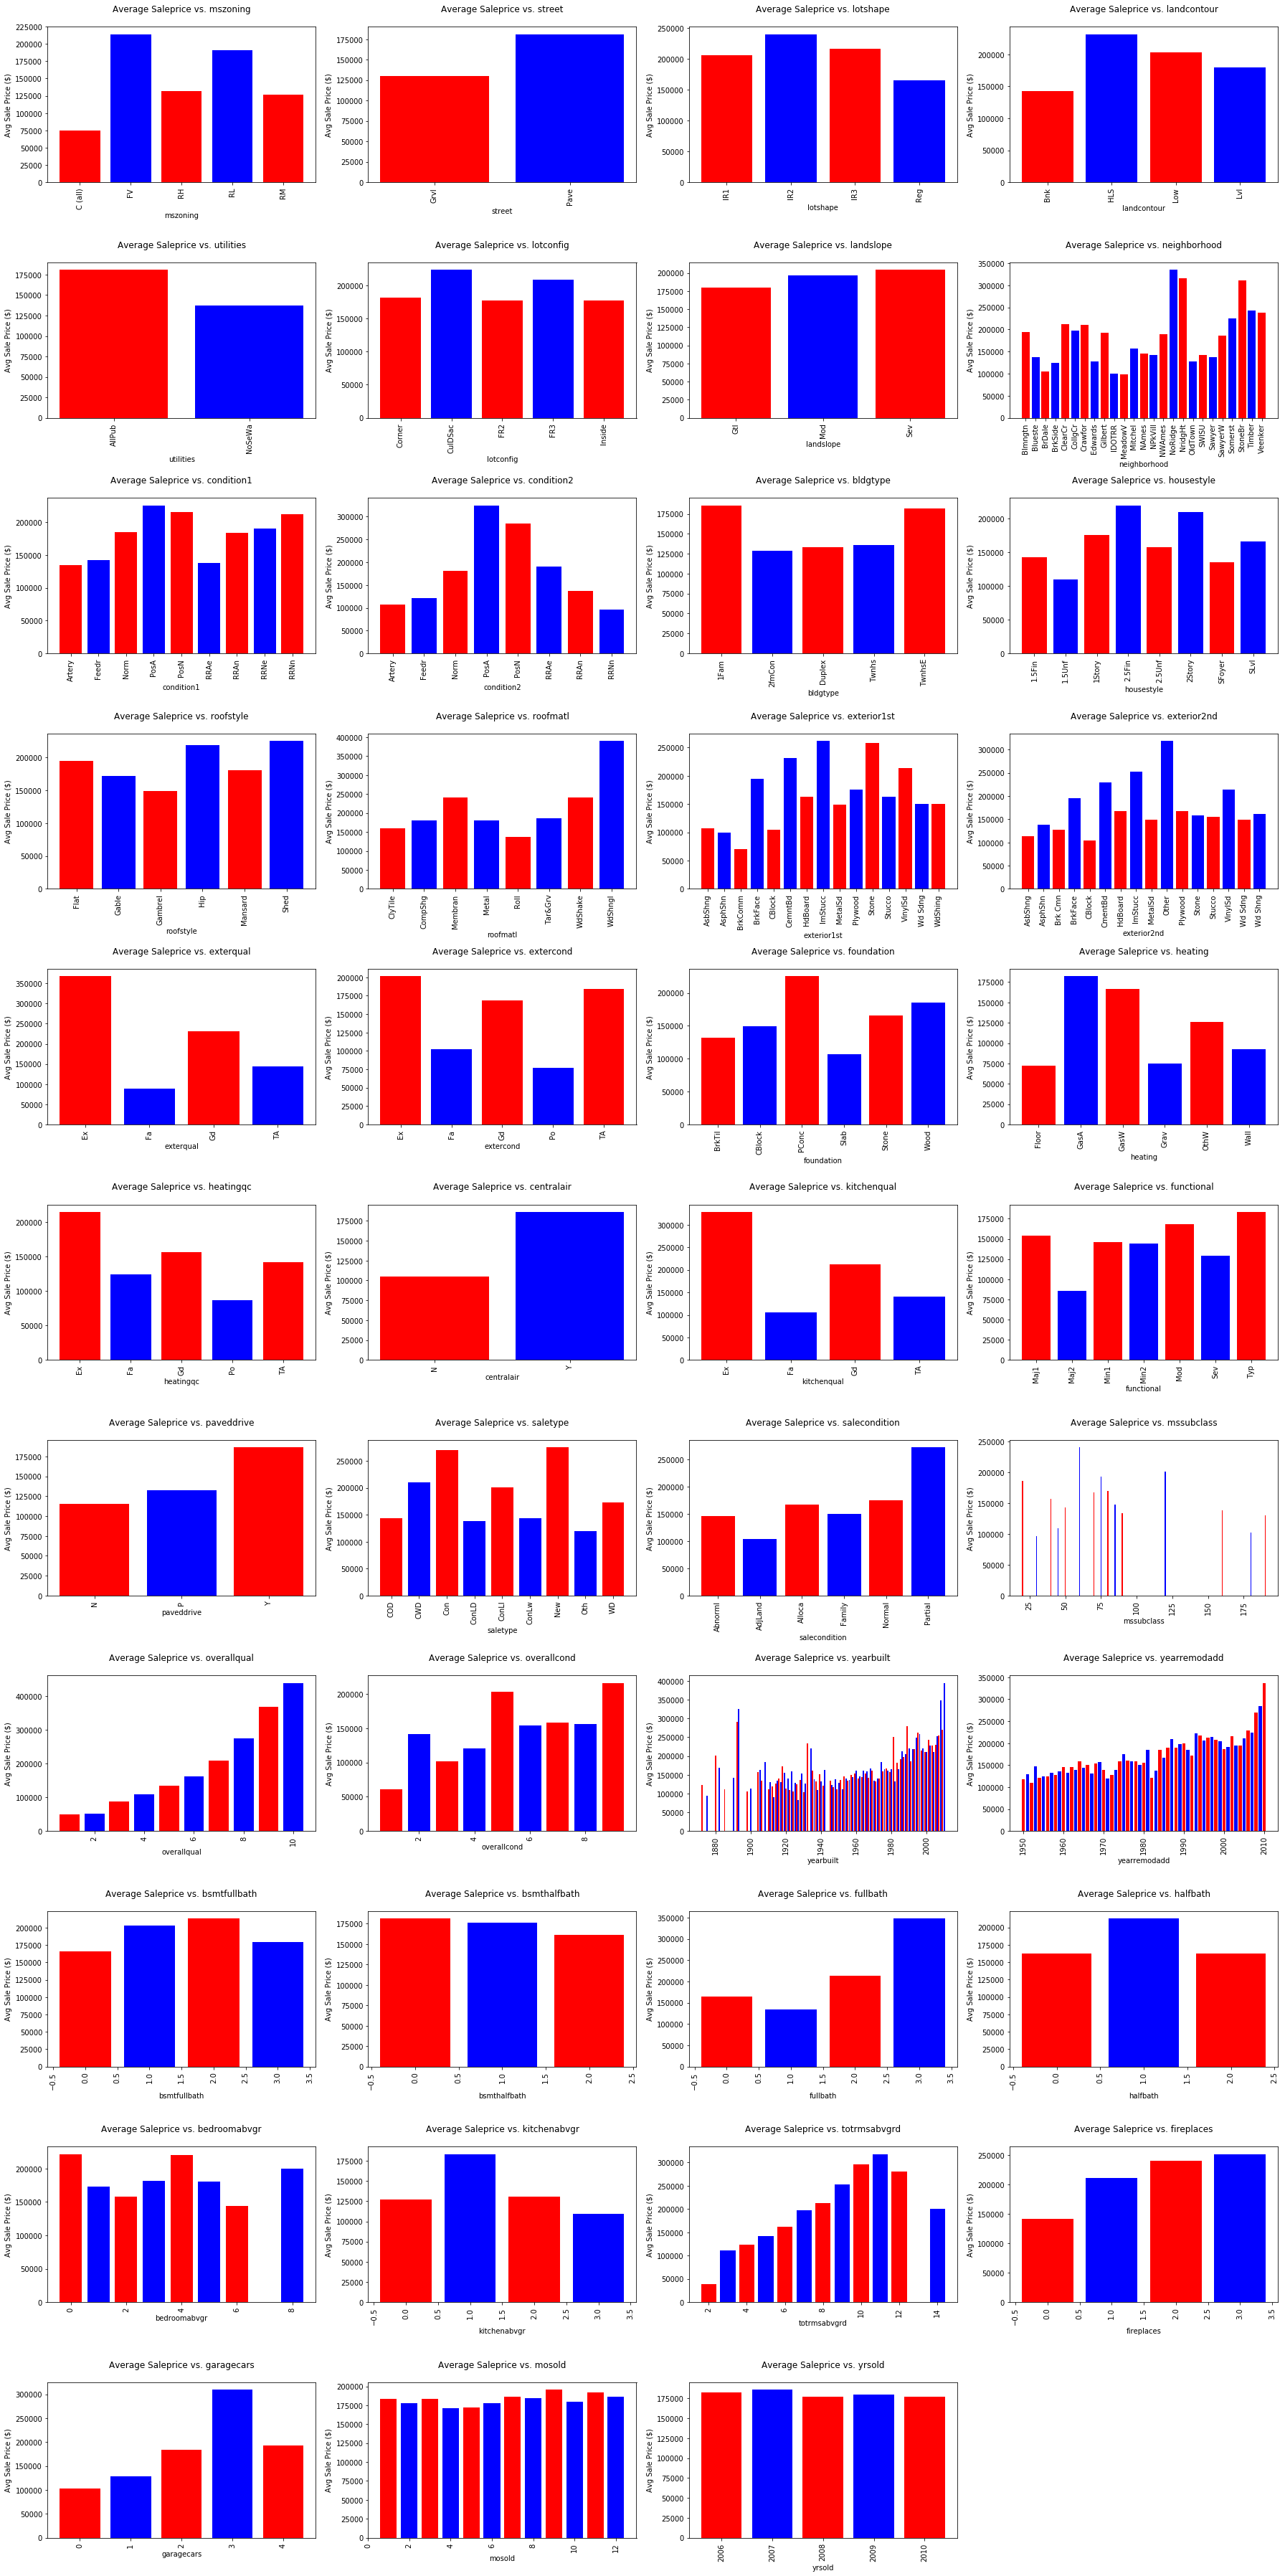

In [128]:
#Analyze all of the categorical variables, with respect to saleprice

#Bar chart with average saleprice on the y-axis and category on the x-axis
cat_cols = str_cat_cols + num_cat_cols
num_rows = len(cat_cols)/4 + 1
num_cols = 4

plt.figure(figsize=(25, 50))

for i in range(len(cat_cols)):
    plt.subplot(num_rows,num_cols,i+1)
    values = house_price.groupby(cat_cols[i])["saleprice"].mean()
    plt.bar(values.index, values, color=("red","blue"))
    plt.title('Average Saleprice vs. ' + cat_cols[i] + '\n')
    plt.ylabel('Avg Sale Price ($)')
    plt.xlabel(cat_cols[i])
    plt.xticks(rotation='vertical')
    
plt.tight_layout()
plt.show()

The variables 'overallqual', 'paveddrive', 'street', 'utilities', 'yearremodadd', 'fireplaces', and 'centralair' all show a linear or exponential relationship with saleprice. However, because most of these categorical variables are not ordinal, the order in which the categories are laid out could be impacting the visualization and our conclusions. Most likely, if the categories were re-ordered, we would see a similar relationship for every variable. So, partly because of that observation, and partly because we don't want the model to be overcomplicated by extraneous variables, I will concentrate on just a few that I think would have the greatest impact on saleprice: 'overallqual', 'paveddrive', 'centralair', and 'yearremodadd'.

In [145]:
#Create new dataframe containing features of interest
sale_df = house_price[['saleprice', 'grlivarea', 'garagearea', 'totalbsmtsf', 'overallqual', 'paveddrive', 'centralair', 'yearremodadd']]

#Convert string categoricals ('paveddrive' and 'centralair') to dummy numerical
unique_paved = ['N', 'P', 'Y']
dummy_paveddrive = []
for row in sale_df['paveddrive']:
    for i in range(len(unique_paved)):
        if row == unique_paved[i]:
            dummy_paveddrive.append(i)
        
sale_df['paveddrive'] = dummy_paveddrive

unique_ac = ['N', 'Y']
dummy_ac = []
for row in sale_df['centralair']:
    for i in range(len(unique_ac)):
        if row == unique_ac[i]:
            dummy_ac.append(i)
        
sale_df['centralair'] = dummy_ac

sale_df.head()

,saleprice,grlivarea,garagearea,totalbsmtsf,overallqual,paveddrive,centralair,yearremodadd
0,208500,1710,548,856,7,2,1,2003
1,181500,1262,460,1262,6,2,1,1976
2,223500,1786,608,920,7,2,1,2002
3,140000,1717,642,756,7,2,1,1970
4,250000,2198,836,1145,8,2,1,2000


### Build your initial model using these features and estimate the parameters using OLS.

In [147]:
#Using scikit-learn LinearRegression():
from sklearn import linear_model

# X is the feature set 
X = sale_df[list(sale_df.columns.drop('saleprice'))]
# Y is the target variable
Y = sale_df['saleprice']

# We create a LinearRegression model object from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [   47.79795124    51.07094136    29.88840163 21257.74178583
  3900.3001063   4995.4512892    402.44083092]

Intercept: 
 -887633.9718888894


According to these results, the constant term for our model is -887,633.97 and the estimated coefficients for each of the features of interest ('grlivarea', 'garagearea', 'totalbsmtsf', 'overallqual', 'paveddrive', 'centralair', and 'yearremodadd') are: 47.79795124, 51.07094136, 29.88840163, 21257.74178583, 3900.3001063, 4995.4512892, and 402.44083092, respectively. Therefore, our linear regression model can be represented by the following equation: 

In [159]:
equation = str(round(lrm.intercept_, 2))
cols = list(sale_df.columns.drop('saleprice'))
for i in range(len(cols)):
    equation =  equation + ' + ' + str(round(lrm.coef_[i], 2)) + '(' + cols[i] + ')'

print('Saleprice ($) = ', equation)

Saleprice ($) =  -887633.97 + 47.8(grlivarea) + 51.07(garagearea) + 29.89(totalbsmtsf) + 21257.74(overallqual) + 3900.3(paveddrive) + 4995.45(centralair) + 402.44(yearremodadd)


In [160]:
#Regression using statsmodel

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     680.2
Date:                Sun, 22 Sep 2019   Prob (F-statistic):               0.00
Time:                        08:49:23   Log-Likelihood:                -17483.
No. Observations:                1460   AIC:                         3.498e+04
Df Residuals:                    1452   BIC:                         3.502e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.876e+05   1.16e+05     -7.684      0.000   -1.11e+06   -6.61e+05
grlivarea       47.7980      2.496     19.147      0.000      42.901      52.695
garagearea      51.0709      6.132      8.329      0.000      39.042      63.099
totalbsmtsf     29.8884      2.874     10.400      0.000      24.251      35.526
overallqual   2.126e+04   1140.237     18.643      0.000     1.9e+04    2.35e+04
paveddrive    3900.3001   2228.133      1.750      0.080    -470.404    8271.004
centralair    4995.4513   4533.414      1.102      0.271   -3897.290    1.39e+04
yearremodadd   402.4408     59.832      6.726      0.000     285.075     519.807
==============================================================================
Omnibus:                      503.301   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63498.342
Skew:                          -0.517   Prob(JB):                         0.00
Kurtosis:                      35.291   Cond. No.                     3.19e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""